In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.stats import norm 
from sklearn.preprocessing import StandardScaler 
from scipy import stats
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

import os
import string
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
from bs4 import BeautifulSoup
import re

from sklearn.model_selection import train_test_split
from sklearn import metrics


In [35]:
df_train = pd.read_csv("drugsComTrain_raw.csv")
df_test = pd.read_csv("drugsComTest_raw.csv")
len_train = df_train.shape[0]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
uniqueID       161297 non-null int64
drugName       161297 non-null object
condition      160398 non-null object
review         161297 non-null object
rating         161297 non-null int64
date           161297 non-null object
usefulCount    161297 non-null int64
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [4]:
df_test['condition'].nunique()

708

In [5]:
df_train['sentiment'] = df_train["rating"].apply(lambda x: 2 if x > 7 else (1 if ((x>4)&(x<=7)) else 0))
df_test['sentiment'] = df_test["rating"].apply(lambda x: 2 if x > 7 else (1 if ((x>4)&(x<=7)) else 0))
solution = df_test['sentiment']

In [6]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,2
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,2
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,1
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,2
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,2


In [7]:
df_all = pd.concat([df_train,df_test]).reset_index()
del df_train, df_test;


Text(0.5, 1.0, 'Number of drugs per top 20 conditions.')

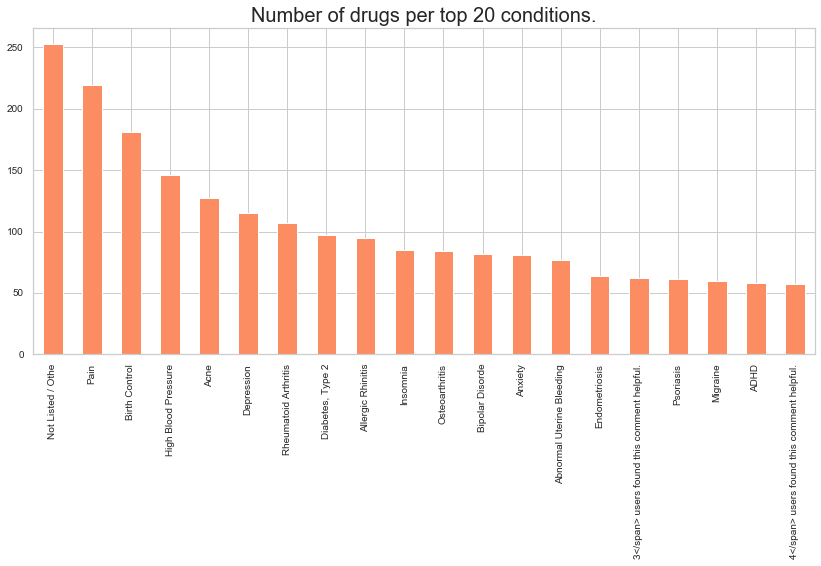

In [16]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="#fc8d62")
plt.xlabel("", fontsize = 30)
plt.ylabel("", fontsize = 30)
plt.title("Number of drugs per top 20 conditions.", fontsize = 20)

Text(0.5, 1.0, 'The number of drugs per bottom 20 conditions.')

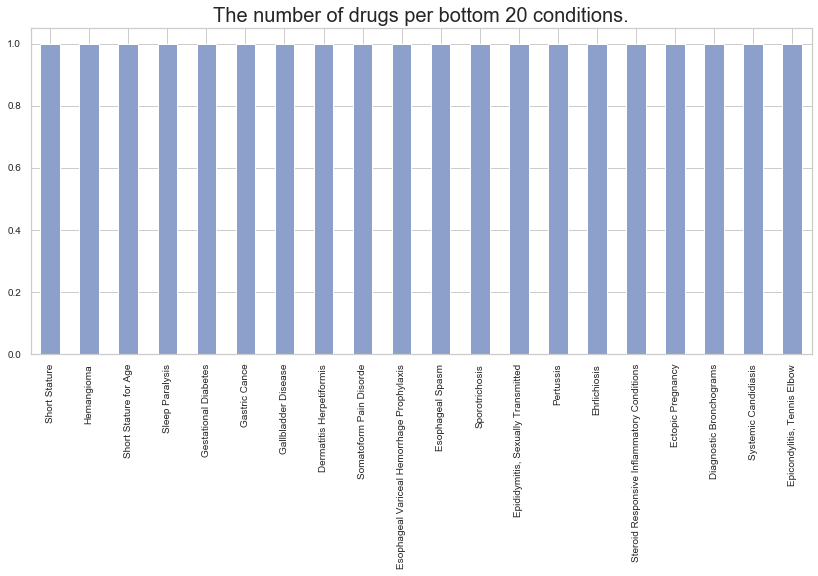

In [18]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)

condition_dn[condition_dn.shape[0]-20:condition_dn.shape[0]].plot(kind="bar", figsize = (14,6), fontsize = 10,color="#8da0cb")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("The number of drugs per bottom 20 conditions.", fontsize = 20)

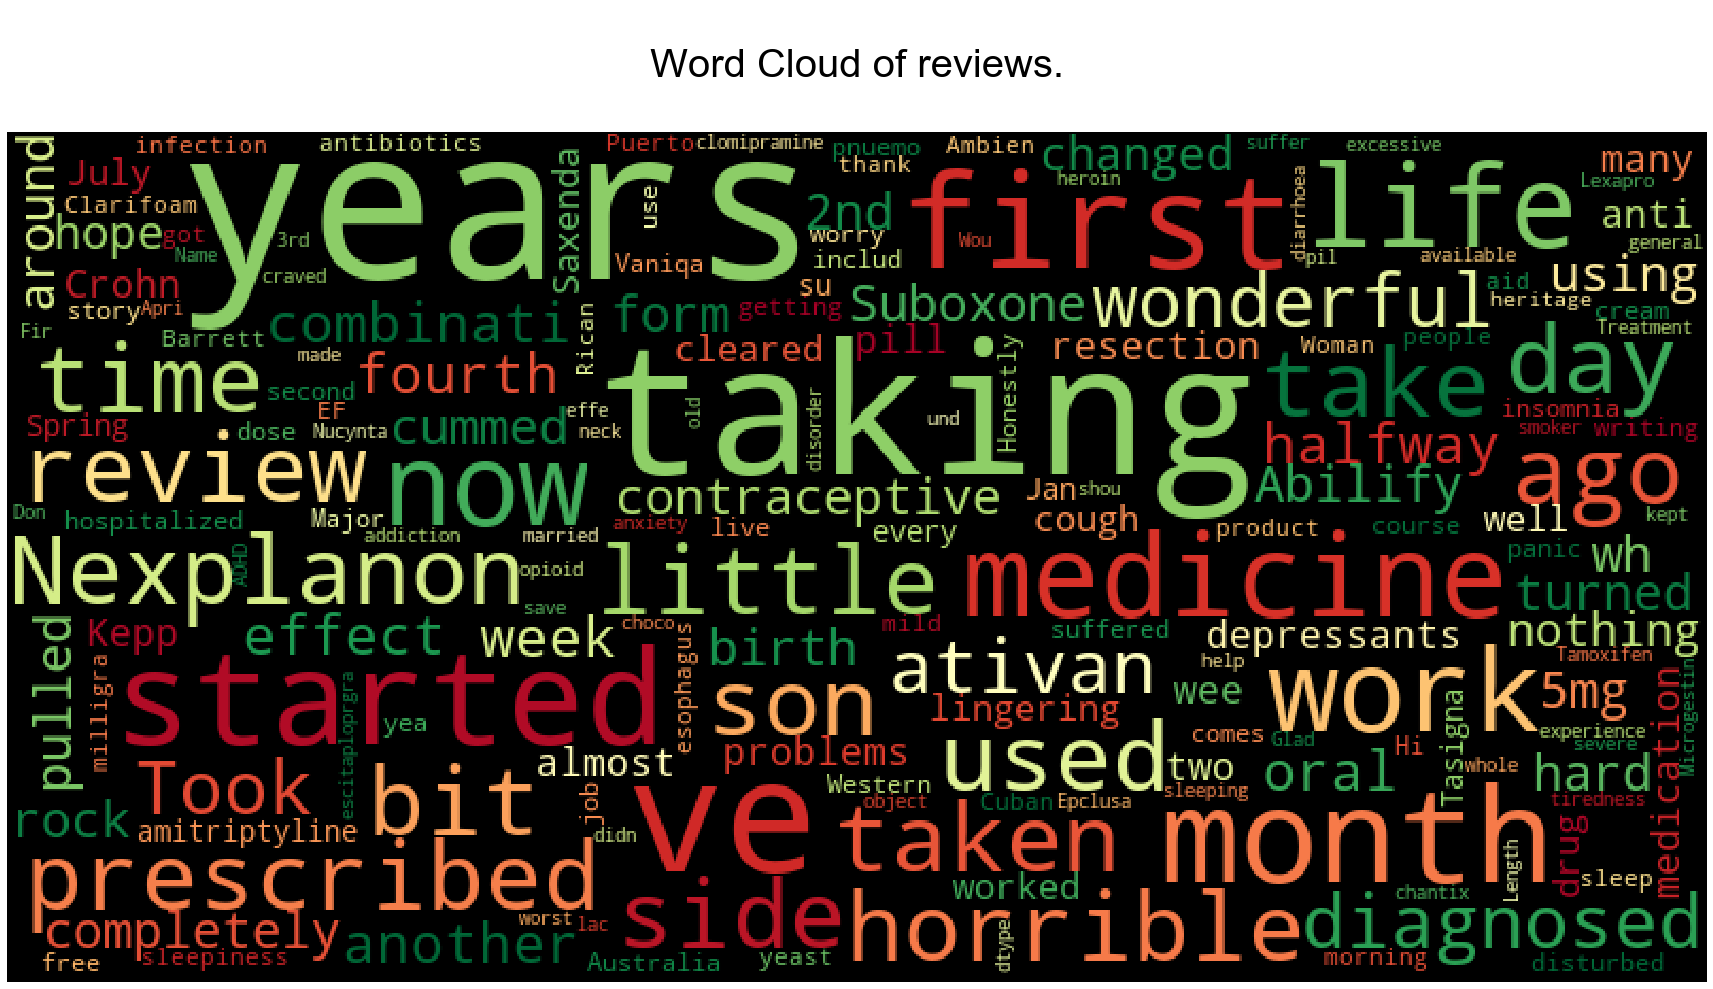

In [33]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                          colormap = "RdYlGn",
                            stopwords = stopwords,
                            max_words = max_words,
                            max_font_size = max_font_size, 
                            random_state = 42,
                            width=800, 
                            height=400,
                            mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df_all["review"], title="\n Word Cloud of reviews. \n")


In [10]:
df_all['date'] = pd.to_datetime(df_all['date'])
df_all['day'] = df_all['date'].dt.day
df_all['year'] = df_all['date'].dt.year
df_all['month'] = df_all['date'].dt.month

In [11]:
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [278]:
stops = set(stopwords.words('english'))

In [279]:
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [280]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    
    words = letters_only.lower().split()
    
    stops = set(stopwords.words('english'))
    
    meaningful_words = [w for w in words if not w in stops]
    
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    
    return( ' '.join(stemming_words))
    

In [281]:
%time df_all['review_clean'] = df_all['review'].apply(review_to_words)

Wall time: 3min 56s


TextBlob code in [Adarsh Chavakula - A gentle introduction to Sentiment Analysis
](https://www.kaggle.com/adarshchavakula/a-gentle-introduction-to-sentiment-analysis)

In [282]:
from textblob import TextBlob
from tqdm import tqdm
reviews = df_all['review_clean']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
df_all["Predict_Sentiment"] = Predict_Sentiment

100%|██████████| 215063/215063 [02:13<00:00, 1606.09it/s]


In [283]:
df_all.head()

,index,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment,day,year,month,review_clean,Predict_Sentiment
0,0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,2,20,2012,5,side effect take combin bystol mg fish oil,0.000000
1,1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,2,27,2010,4,son halfway fourth week intuniv becam concern ...,0.114583
2,2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,1,14,2009,12,use take anoth oral contracept pill cycl happi...,0.105000
3,3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,2,3,2015,11,first time use form birth control glad went pa...,0.300000
4,4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,2,27,2016,11,suboxon complet turn life around feel healthie...,0.147037


Made reviews clean, but get strange results that are getting correlation worse. (0.34853791 -> 0.23246)


In [284]:
 np.corrcoef(df_all["Predict_Sentiment"], df_all["rating"])

array([[1.        , 0.23246791],
       [0.23246791, 1.        ]])

In [285]:
def review_to_words(raw_review):

    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    words = letters_only.lower().split()
    return( ' '.join(words))

In [286]:
%time df_all['review_clean2'] = df_all['review'].apply(review_to_words)

Wall time: 27.5 s


In [287]:
from textblob import TextBlob
from tqdm import tqdm
reviews = df_all['review_clean2']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
df_all["Predict_Sentiment2"] = Predict_Sentiment

100%|██████████| 215063/215063 [03:24<00:00, 1049.29it/s]


In [288]:
np.corrcoef(df_all["Predict_Sentiment2"], df_all["rating"])

array([[1.        , 0.34597794],
       [0.34597794, 1.        ]])

Only using stopwords 0.34853791 -> 0.34597794

add other features

In [289]:
df_all.head()

,index,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment,day,year,month,review_clean,Predict_Sentiment,review_clean2,Predict_Sentiment2
0,0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,2,20,2012,5,side effect take combin bystol mg fish oil,0.000000,it has no side effect i take it in combination...,0.000000
1,1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,2,27,2010,4,son halfway fourth week intuniv becam concern ...,0.114583,my son is halfway through his fourth week of i...,0.168333
2,2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,1,14,2009,12,use take anoth oral contracept pill cycl happi...,0.105000,i used to take another oral contraceptive whic...,0.067210
3,3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,2,3,2015,11,first time use form birth control glad went pa...,0.300000,this is my first time using any form of birth ...,0.179545
4,4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,2,27,2016,11,suboxon complet turn life around feel healthie...,0.147037,suboxone has completely turned my life around ...,0.194444


In [290]:
list(df_all['review'].values)[0]

'"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"'

code in [Jagan - Stop the S@#$ - Toxic Comments EDA](https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda)

In [291]:

df_all['count_sent']=df_all["review"].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Word count in each comment:
df_all['count_word']=df_all["review_clean"].apply(lambda x: len(str(x).split()))
df_all['count_word2']=df_all["review_clean2"].apply(lambda x: len(str(x).split()))

#Unique word count:
df_all['count_unique_word']=df_all["review_clean"].apply(lambda x: len(set(str(x).split())))
df_all['count_unique_word2']=df_all["review_clean2"].apply(lambda x: len(set(str(x).split())))

#Letter count:
df_all['count_letters']=df_all["review_clean"].apply(lambda x: len(str(x)))
df_all['count_letters2']=df_all["review_clean2"].apply(lambda x: len(str(x)))

#punctuation count:
df_all["count_punctuations"] = df_all["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count:
df_all["count_words_upper"] = df_all["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#title case words count:
df_all["count_words_title"] = df_all["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords:
stops = set(stopwords.words('english'))
df_all["count_stopwords"] = df_all["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stops]))

#Average length of the words:
df_all["mean_word_len"] = df_all["review_clean"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_all["mean_word_len2"] = df_all["review_clean2"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# season
- 1(spring): 3~5 month
- 2(summer): 6~8 month
- 3(fall): 9~11 month
- 4(winter): 12~2 month

In [292]:
df_all['season'] = df_all["month"].apply(lambda x: 1 if ((x>2) & (x<6)) else(2 if (x>5) & (x<9) else (3 if (x>8) & (x<12) else 4)))

In [293]:
df_all.head()

,index,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment,day,year,month,review_clean,Predict_Sentiment,review_clean2,Predict_Sentiment2,count_sent,count_word,count_word2,count_unique_word,count_unique_word2,count_letters,count_letters2,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,mean_word_len2,season
0,0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,2,20,2012,5,side effect take combin bystol mg fish oil,0.000000,it has no side effect i take it in combination...,0.000000,1,8,16,8,15,42,74,3,1,6,7,4.375000,3.687500,1
1,1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,2,27,2010,4,son halfway fourth week intuniv becam concern ...,0.114583,my son is halfway through his fourth week of i...,0.168333,2,65,140,54,96,371,714,23,2,13,69,4.723077,4.107143,1
2,2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,1,14,2009,12,use take anoth oral contracept pill cycl happi...,0.105000,i used to take another oral contraceptive whic...,0.067210,2,69,134,48,88,399,711,34,6,15,59,4.797101,4.313433,4
3,3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,2,3,2015,11,first time use form birth control glad went pa...,0.300000,this is my first time using any form of birth ...,0.179545,1,39,87,26,53,225,423,15,4,9,45,4.794872,3.873563,3
4,4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,2,27,2016,11,suboxon complet turn life around feel healthie...,0.147037,suboxone has completely turned my life around ...,0.194444,1,59,129,52,86,380,674,28,7,15,60,5.457627,4.232558,3


In [294]:
df_train = df_all[:len_train]
df_test = df_all[len_train:]

# Applying the LGBM Classifier

In [295]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier


target = df_train['sentiment']
feats = ['usefulCount','day','year','month','Predict_Sentiment','Predict_Sentiment2', 'count_sent',
 'count_word', 'count_word2', 'count_unique_word', 'count_unique_word2', 'count_letters', 'count_letters2', 'count_punctuations',
 'count_words_upper', 'count_words_title', 'count_stopwords', 'mean_word_len', 'mean_word_len2', 'season']

sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42) 
feature_importance_df = pd.DataFrame() 
    
clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
        
clf.fit(trn_x, trn_y, 
        eval_set= [(trn_x, trn_y), (val_x, val_y)], 
        eval_metric='multi_logloss', verbose=100, early_stopping_rounds=100  #30
    )

sub_preds = clf.predict(df_test[feats])
        
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.77682	training's multi_logloss: 0.77682	valid_1's multi_logloss: 0.801644	valid_1's multi_logloss: 0.801644
[200]	training's multi_logloss: 0.748873	training's multi_logloss: 0.748873	valid_1's multi_logloss: 0.791619	valid_1's multi_logloss: 0.791619
[300]	training's multi_logloss: 0.725003	training's multi_logloss: 0.725003	valid_1's multi_logloss: 0.783371	valid_1's multi_logloss: 0.783371
[400]	training's multi_logloss: 0.702166	training's multi_logloss: 0.702166	valid_1's multi_logloss: 0.77562	valid_1's multi_logloss: 0.77562
[500]	training's multi_logloss: 0.681613	training's multi_logloss: 0.681613	valid_1's multi_logloss: 0.768582	valid_1's multi_logloss: 0.768582
[600]	training's multi_logloss: 0.662203	training's multi_logloss: 0.662203	valid_1's multi_logloss: 0.761826	valid_1's multi_logloss: 0.761826
[700]	training's multi_logloss: 0.643368	training's multi_logloss: 0.643368	v

# Predicting Accuracy score, finding important features and checking classification matrix

In [296]:
from sklearn.metrics import accuracy_score

accuracy_score(sub_preds,solution)

0.8073689692370644

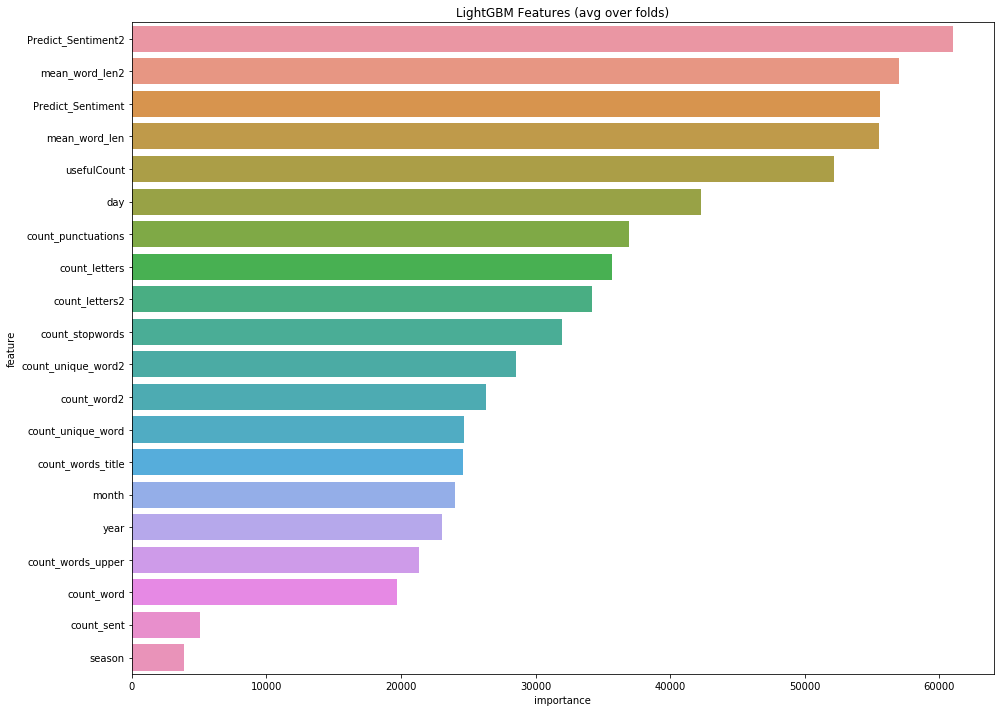

In [297]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [298]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred=sub_preds, y_true=solution)

array([[ 9555,   214,  3728],
       [  983,  3772,  3165],
       [ 1928,   339, 30082]], dtype=int64)

# Analysis by emotional dictionary 

In [299]:
word_table = pd.read_csv("inquirerbasic.csv")

In [300]:
word_table.head()

,Entry,Source,Positiv,Negativ,Pstv,Affil,Ngtv,Hostile,Strong,Power,Weak,Submit,Active,Passive,Pleasur,Pain,Feel,Arousal,EMOT,Virtue,Vice,Ovrst,Undrst,Academ,Doctrin,Econ@,Exch,ECON,Exprsv,Legal,Milit,Polit@,POLIT,Relig,Role,COLL,Work,Ritual,SocRel,Race,Kin@,MALE,Female,Nonadlt,HU,ANI,PLACE,Social,Region,Route,Aquatic,Land,Sky,Object,Tool,Food,Vehicle,BldgPt,ComnObj,NatObj,BodyPt,ComForm,COM,Say,Need,Goal,Try,Means,Persist,Complet,Fail,NatrPro,Begin,Vary,Increas,Decreas,Finish,Stay,Rise,Exert,Fetch,Travel,Fall,Think,Know,Causal,Ought,Perceiv,Compare,Eval@,EVAL,Solve,Abs@,ABS,Quality,Quan,NUMB,ORD,CARD,FREQ,DIST,Time@,TIME,Space,POS,DIM,Rel,COLOR,Self,Our,You,Name,Yes,No,Negate,Intrj,IAV,DAV,SV,IPadj,IndAdj,PowGain,PowLoss,PowEnds,PowAren,PowCon,PowCoop,PowAuPt,PowPt,PowDoct,PowAuth,PowOth,PowTot,RcEthic,RcRelig,RcGain,RcLoss,RcEnds,RcTot,RspGain,RspLoss,RspOth,RspTot,AffGain,AffLoss,AffPt,AffOth,AffTot,WltPt,WltTran,WltOth,WltTot,WlbGain,WlbLoss,WlbPhys,WlbPsyc,WlbPt,WlbTot,EnlGain,EnlLoss,EnlEnds,EnlPt,EnlOth,EnlTot,SklAsth,SklPt,SklOth,SklTot,TrnGain,TrnLoss,TranLw,MeansLw,EndsLw,ArenaLw,PtLw,Nation,Anomie,NegAff,PosAff,SureLw,If,NotLw,TimeSpc,FormLw,Othtags,Defined
0,A,H4Lvd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DET ART,| article: Indefinite singular article--some o...
1,ABANDON,H4Lvd,NaN,Negativ,NaN,NaN,Ngtv,NaN,NaN,NaN,Weak,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AffLoss,NaN,NaN,AffTot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUPV,|
2,ABANDONMENT,H4,NaN,Negativ,NaN,NaN,NaN,NaN,NaN,NaN,Weak,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Noun,|
3,ABATE,H4Lvd,NaN,Negativ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Passive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Decreas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IAV,NaN,NaN,N

In [301]:
#Make lists of sentiment
#Positive lis of words   
temp_Positiv = []
Positiv_word_list = []
for i in range(0,len(word_table.Positiv)):
    if word_table.iloc[i,2] == "Positiv":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Positiv.append(temp2)

Positiv_word_list = list(set(temp_Positiv))
len(temp_Positiv)
len(Positiv_word_list)  

#Negative list of words          
temp_Negativ = []
Negativ_word_list = []
for i in range(0,len(word_table.Negativ)):
    if word_table.iloc[i,3] == "Negativ":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Negativ.append(temp2)
        
Negativ_word_list = list(set(temp_Negativ))
len(temp_Negativ)
len(Negativ_word_list)  


2006

In [302]:
#counting the words
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(vocabulary = Positiv_word_list)
content = df_test['review_clean']
X = vectorizer.fit_transform(content)
f = X.toarray()
f = pd.DataFrame(f)
f.columns=Positiv_word_list
df_test["num_Positiv_word"] = f.sum(axis=1)

vectorizer2 = CountVectorizer(vocabulary = Negativ_word_list)
content = df_test['review_clean']
X2 = vectorizer2.fit_transform(content)
f2 = X2.toarray()
f2 = pd.DataFrame(f2)
f2.columns=Negativ_word_list
df_test["num_Negativ_word"] = f2.sum(axis=1)

In [303]:
#Decide the sentiment
df_test["Positiv_ratio"] = df_test["num_Positiv_word"]/(df_test["num_Positiv_word"]+df_test["num_Negativ_word"])
df_test["sentiment_by_dic"] = df_test["Positiv_ratio"].apply(lambda x: 1 if (x>=0.5) else (0 if (x<0.5) else 0.5))

df_test.head()

,index,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment,day,year,month,review_clean,Predict_Sentiment,review_clean2,Predict_Sentiment2,count_sent,count_word,count_word2,count_unique_word,count_unique_word2,count_letters,count_letters2,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,mean_word_len2,season,num_Positiv_word,num_Negativ_word,Positiv_ratio,sentiment_by_dic
161297,0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,2012-02-28,22,2,28,2012,2,tri antidepress year citalopram fluoxetin amit...,-0.122222,i ve tried a few antidepressants over the year...,0.000000,1,36,68,33,52,252,406,22,2,4,27,6.027778,4.985294,4,NaN,NaN,NaN,0.5
161298,1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,2009-05-17,17,2,17,2009,5,son crohn diseas done well asacol complaint sh...,-0.300000,my son has crohn s disease and has done very w...,0.566667,1,24,50,24,41,141,248,13,0,4,22,4.916667,3.980000,1,NaN,NaN,NaN,0.5
161299,2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,2017-09-29,3,2,29,2017,9,quick reduct symptom,0.333333,quick reduction of symptoms,0.333333,1,3,4,3,4,20,27,2,0,1,1,6.000000,6.000000,3,NaN,NaN,NaN,0.5
161300,3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,2017-03-05,35,2,5,2017,3,contrav combin drug use alcohol smoke opioid c...,0.700000,contrave combines drugs that were used for alc...,0.139063,1,64,151,58,102,371,730,42,10,14,71,4.812500,3.841060,1,NaN,NaN,NaN,0.5
161301,4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,2015-10-22,4,2,22,2015,10,birth control one cycl read review type simila...,0.205476,i have been on this birth control for one cycl...,0.234537,1,63,148,53,89,375,733,17,10,17,80,4.968254,3.959459,3,NaN,NaN,NaN,0.5


In [304]:

df_test =  userful_count(df_test) 
df_test['usefulCount'] = df_test['usefulCount']/df_test['user_size']

# Combining the two sentiment scores to get a final score

In [305]:
df_test['machine_pred'] = sub_preds

df_test['total_pred'] = (df_test['machine_pred'] + df_test['sentiment_by_dic'])*df_test['usefulCount']

In [306]:
df_test = df_test.groupby(['condition','drugName']).agg({'total_pred' : ['mean']})

In [307]:
df_test.head(20)

total_pred
                                                                         mean
condition                                    drugName                        
0</span> users found this comment helpful.   Aviane                       0.0
                                             Chantix                      0.0
                                             Depo-Provera                 0.0
                                             Drysol                       0.0
                                             Gianvi                       0.0
                                             Implanon                     0.0
                                             Loestrin 24 Fe               0.0
                                             Lutera                       0.0
                                             Microgestin Fe 1 / 20        0.0
                                             Nexplanon                    0.0
                                             Remicade                     0.0
                                             Sprintec                     0.0
                                             Suboxone                     0.0
                                             Testim                       0.0
                                             Treximet                     0.0
                                             Tri-Sprintec                 0.0
                                             Yaz                          0.0
100</span> users found this comment helpful. Estrace Vaginal Cream      150.0
105</span> users found this comment helpful. Viagra                     262.5
10</span> users found this comment helpful.  Biafine                      2.5

In [308]:
df_test.sort_values(["condition"], axis=0, ascending=True, inplace=True)
df_test


total_pred
                                                                                 mean
condition                                    drugName                                
0</span> users found this comment helpful.   Aviane                          0.000000
                                             Tri-Sprintec                    0.000000
                                             Treximet                        0.000000
                                             Testim                          0.000000
                                             Suboxone                        0.000000
                                             Sprintec                        0.000000
                                             Remicade                        0.000000
                                             Nexplanon                       0.000000
                                             Microgestin Fe 1 / 20           0.000000
                                             Lutera                          0.000000
                                             Loestrin 24 Fe                  0.000000
                                             Implanon                        0.000000
                                             Gianvi                          0.000000
                                             Drysol                          0.000000
                                             Depo-Provera                    0.000000
                                             Chantix                         0.000000
                                             Yaz                             0.000000
100</span> users found this comment helpful. Estrace Vaginal Cream         150.000000
105</span> users found this comment helpful. Viagra                        262.500000
10</span> users found this comment helpful.  Biafine                         2.500000
                                             Yasmin                          2.500000
                                             Tri-Sprintec                    2.500000
                                             Saphris                         1.500000
                                             Ortho Tri-Cyclen Lo             2.500000
                                             Viibryd                         0.500000
                                             Lunesta                         2.500000
                                             Flonase                         2.500000
                                             Effexor XR                      2.500000
                                             Navane                          2.500000
11</span> users found this comment helpful.  Lexapro                         6.875000
...                                                                               ...
ibromyalgia                                  Milnacipran                     0.175258
lic Acid Deficiency                          L-methylfolate                 24.583333
                                             Deplin                        146.666667
llicle Stimulation                           Menotropins                     8.750000
                                             Menopur                         8.750000
                                             Follicle stimulating hormone    3.125000
                                             Gonal-f                         3.125000
m Pain Disorde                               Amitriptyline                  11.250000
                                             Venlafaxine                     0.000000
mance Anxiety                                Propranolol                     1.272087
me                                           Bevacizumab                     7.500000
min / saxagliptin)                           Metformin / saxagliptin        10.031250
min / sitagliptin)                           Metformin / sitagliptin        11.789062
min)                             

In [318]:
df = df_test.reset_index('condition')

In [319]:
df.head()

,condition,total_pred
,,mean
drugName,,
Aviane,0</span> users found this comment helpful.,0.0
Tri-Sprintec,0</span> users found this comment helpful.,0.0
Treximet,0</span> users found this comment helpful.,0.0
Testim,0</span> users found this comment helpful.,0.0
Suboxone,0</span> users found this comment helpful.,0.0


In [320]:
df = df[~df.condition.str.contains("helpful")]

In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5311 entries, Kapvay to Voltaren
Data columns (total 2 columns):
(condition, )         5311 non-null object
(total_pred, mean)    5311 non-null float64
dtypes: float64(1), object(1)
memory usage: 124.5+ KB


In [322]:
df

,condition,total_pred
,,mean
drugName,,
Kapvay,ADHD,0.145382
Lisdexamfetamine,ADHD,0.067770
Metadate CD,ADHD,0.090079
Metadate ER,ADHD,0.006661
Methamphetamine,ADHD,0.110124
Methylin,ADHD,0.040705
Methylin ER,ADHD,0.024423
Methylphenidate,ADHD,0.058259
